## Section 1: Project Setup & Business Problem
####  Business Problem Statement:
A telecom company is experiencing significant customer churn, leading to revenue loss.
This project aims to analyze the key drivers of churn and build a predictive model to identify at-risk customers. The ultimate goal is to provide actionable recommendations for targeted retention strategies to reduce the churn rate by 5% in the next quarter.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.constraints import max_norm

In [3]:
# Load the dataset
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
data = pd.read_csv(url)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Section 2: Data Cleaning and Preprocessing

In [4]:
# Standardizing column formats for analysis.

# Convert SeniorCitizen from 0/1 to No/Yes for better readability in EDA
data.SeniorCitizen.replace([0, 1], ["No", "Yes"], inplace=True)

# TotalCharges for new customers are blank; this is not missing data, it's 0.
# Convert to a numeric type for calculations.
data.TotalCharges.replace([" "], ["0"], inplace=True)
data.TotalCharges = data.TotalCharges.astype(float)

# customerID is a unique identifier and not a predictive feature.
data.drop("customerID", axis=1, inplace=True)


## Section 3: Exploratory Data Analysis (EDA) 

### Insight 1: What is the overall churn rate?

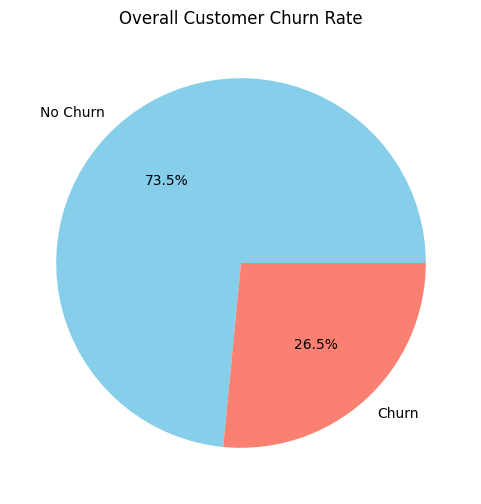

Insight: The company has a significant churn rate of nearly 27%, confirming the business problem.


In [15]:
plt.figure(figsize=(6, 6))
data['Churn'].value_counts().plot(kind='pie', autopct='%.1f%%', labels=['No Churn', 'Churn'], colors=['skyblue', 'salmon'])
plt.title('Overall Customer Churn Rate')
plt.ylabel('')
plt.show()
print("Insight: The company has a significant churn rate of nearly 27%, confirming the business problem.")


### Insight 2: How does the contract type affect churn?

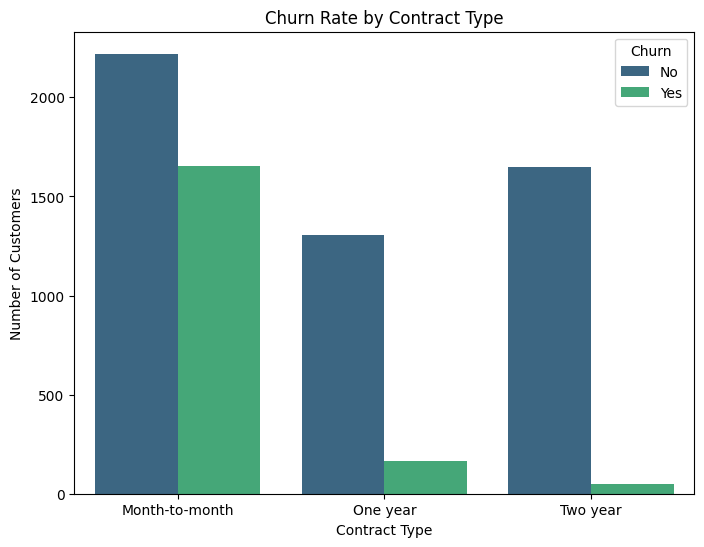

Insight: Customers on Month-to-Month contracts churn at a dramatically higher rate. This is a major risk factor.


In [6]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=data, palette='viridis')
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.show()
print("Insight: Customers on Month-to-Month contracts churn at a dramatically higher rate. This is a major risk factor.")

### Insight 3: How does tenure affect churn?

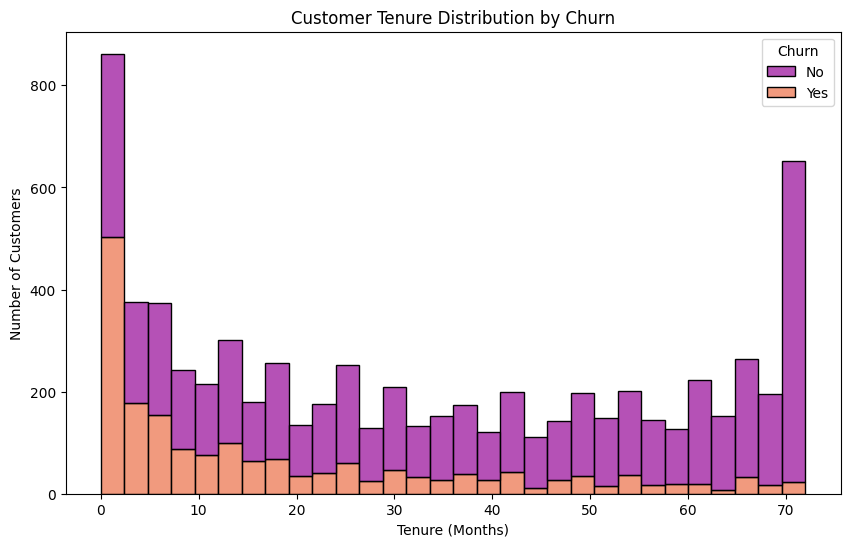

Insight: New customers (low tenure) are far more likely to churn. Loyalty increases significantly over time.


In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='tenure', hue='Churn', multiple='stack', bins=30, palette='plasma')
plt.title('Customer Tenure Distribution by Churn')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()
print("Insight: New customers (low tenure) are far more likely to churn. Loyalty increases significantly over time.")

## Section 4: Feature Engineering & Model Preparation

In [9]:
# Preparing the data for the predictive model.

# Convert Churn to a binary 0/1 for the model.
data.Churn.replace(["Yes", "No"], [1, 0], inplace=True)

# Convert all categorical variables into numeric format using one-hot encoding.
data_dummies = pd.get_dummies(data)


In [10]:
# Define our features (X) and target (y).
X = data_dummies.drop("Churn", axis=1)
y = data_dummies.Churn

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)


## Section 5: Building and Training the Predictive Model

In [14]:
model = Sequential()
model.add(Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(8, activation='relu', kernel_constraint=max_norm(3)))
model.add(Dropout(rate=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=10, verbose=0) # verbose=0 for cleaner output


C:\Users\Lenovo\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


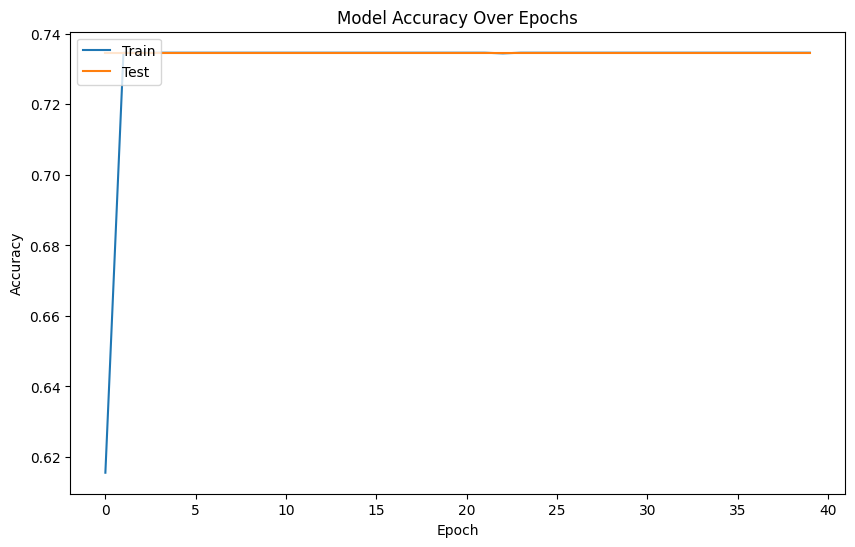

In [12]:
# Plotting model accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Section 6: Model Evaluation from a Business Perspective


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

--- Business-Focused Model Evaluation ---
Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       0.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.37      0.50      0.42      1409
weighted avg       0.54      0.73      0.62      1409



C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


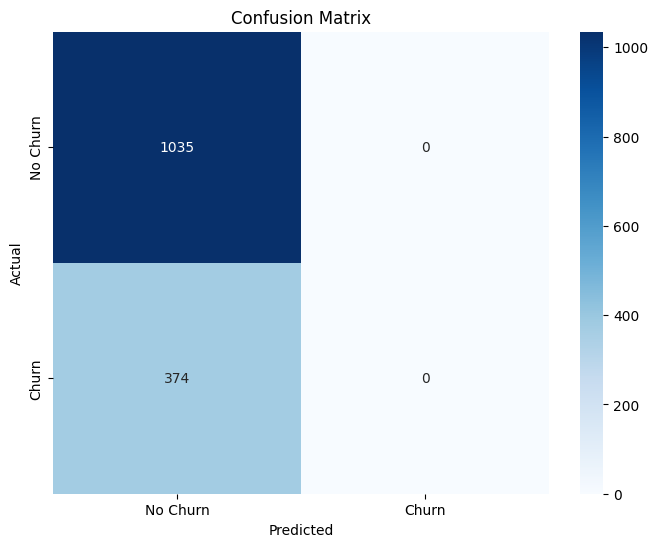


Interpretation of the Confusion Matrix for Business:
- True Negatives (Top-Left): Customers we correctly predicted would not churn.
- True Positives (Bottom-Right): At-risk customers we correctly identified. This is our target group for retention offers.
- False Positives (Top-Right): Customers we incorrectly flagged as at-risk. Offering them a discount is an unnecessary cost.
- False Negatives (Bottom-Left): At-risk customers our model missed. This represents lost revenue.



In [13]:
predictions = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions)

print("\n--- Business-Focused Model Evaluation ---")
print("Classification Report:\n", report)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("""
Interpretation of the Confusion Matrix for Business:
- True Negatives (Top-Left): Customers we correctly predicted would not churn.
- True Positives (Bottom-Right): At-risk customers we correctly identified. This is our target group for retention offers.
- False Positives (Top-Right): Customers we incorrectly flagged as at-risk. Offering them a discount is an unnecessary cost.
- False Negatives (Bottom-Left): At-risk customers our model missed. This represents lost revenue.
""")


# Section 7: Summary of Findings & Actionable Recommendations


### Summary & Actionable Recommendations

Based on the analysis, a profile of a high-risk customer has emerged:
A customer on a Month-to-Month contract, who has been with the company for less than a year.

To address this, the following data-driven recommendations are proposed:

#### 1.Targeted Campaign for Contract Conversion:
    - Action: Launch a marketing campaign targeting month-to-month customers with 2-12 months of tenure.
    - Offer: Provide a one-time 15% discount for converting to a one-year contract.
    - Impact: This directly addresses the single biggest factor driving churn, converting high-risk customers into lower-risk, loyal ones.

#### 2.Enhance New Customer Onboarding:**
    - Action: Implement a proactive support outreach for all new customers within their first 60 days.
    - Offer: A dedicated support line or a check-in call to ensure service satisfaction.
    - Impact: This mitigates early-stage churn by addressing service issues before they lead to dissatisfaction.

#### 3.Utilize the Predictive Model:**
    - Action: Use the trained model to generate a weekly list of customers with the highest churn probability.
    - Offer: The retention team can use this list to make personalized retention offers.
    - Impact: Moves the company from a reactive to a proactive retention strategy, saving customers before they decide to leave.
